In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Input(3)
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)
    
    # State2 (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]
    
    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100.0
    # Volume of CSTR (m^3)
    V = 100.0
    # Density of A-B mixture (kg/m^3)
    rho = 1000.0
    # Heat Capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A-B (J/mol)
    mdelH = 5.0e4
    # E - Activation energy in the Arrhenius Equation(J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750.0
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall heat transfer coefficient (W/m^2-K)
    # A = Area - this value is specific for the U calcualtion (m^2)
    UA = 5.0e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca
    
    # Calculate concentration derivative
    dCadt = q/V*(Caf-Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf-T)+mdelH/(rho*Cp)*rA + UA/V/rho/Cp*(Tc-T)
    
    # Return xdot
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

# Steady state initial condition for the states
Ca_ss = 0.87725
T_ss = 324.4754
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss


# Steady state initial condition
u_ss = 300.0
# Feed temperature (K)
Tf = 350.0
# Feed concentration (mol/m^3)
Caf = 1.0

# Time interval (min)
t = np.linspace(0,25,251)

# store results for plotting
Ca = np.ones(len(t))*Ca_ss
T = np.ones(len(t))*T_ss
u = np.ones(len(t))*u_ss

# Step cooling temperature to 295
u[10:100]= 303.0
u[100:190]= 297.0
u[190:]= 300.0

# simulate CSTR
for i in range(len(t)-1):
    ts = [t[i],t[i+1]]
    y = odeint(cstr,x0,ts,args = (u[i+1],Tf,Caf))
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]
    


# Construct results and save data file
# Column 1 = time
# Colume 2 = cooling temperature
# Colume 3 = reactor tempature
data = np.vstack((t,u,T)) # vertical stack
data = data.T
np.savetxt('data_double.txt',data,delimiter = ',')

# plot the results
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,u,'b--',linewidth=3)
plt.ylabel('Cooling T (K)')
plt.legend(['Jacket Temperature'],loc='best')

plt.subplot(3,1,2)
plt.plot(t,Ca,'r-',linewidth=3)
plt.ylabel('Ca (mol/L)')
plt.legend(['Reactor Concentration'],loc='best')

plt.subplot(3,1,3)
plt.plot(t,T,'k.-',linewidth=3)
plt.ylabel('T (K)')
plt.xlabel('Time (min)')
plt.legend(['Reactor Temperature'],loc='best')

plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# import csv data file
# column 1 = time (t)
# column 2 = input (u)
# column 3 = output (yp)
data = np.loadtxt('data_double.txt',delimiter=',')
u0 = data[0,1]
yp0 = data[0,2]
t = data[:,0].T
u = data[:,1].T
yp = data[:,2].T

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    # y = output
    # t = time
    # uf = input linear function(for time shift)
    # Km = model gain
    # taum = model time constant
    # thetam = model time constant
    # time-shift u
    try:
        if (t-thetam)<0:
            um=uf(0.0)
        else:
            um=uf(t-thetam)
    except:
        #print('Error with time extrapolation: '+str(t))
        um=u0
    # this model is different from traditional fopdt model!!
    # why need to cut yp0 and u0
    dydt = (-(y-yp0) + Km*(um-u0))/taum
    return dydt

# simulate FOPDT model with x = [Km,taum,thetam]
def sim_model(x):
    # input_arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns) 
    # initial condition
    ym[0] = yp0
    # loop through time steps
    for i in range(0,ns-1):
        ts = [delta_t*i,delta_t*(i+1)]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1]=y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0]= 3.0 # Km
x0[1]= 3.0 # taum
x0[2]= 0.0 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km,taum,thetam
# bounds on variables
bnds = ((-1.0e10,1.0e10),(0.01,1.0e10),(0.0,5.0))
solution = minimize(objective, x0,method='SLSQP',bounds=bnds)
print(solution)
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results

plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()

Initial SSE Objective: 1803.53946929
     fun: 589.47267973974579
     jac: array([  -21.99588776,  1955.19274139,    84.10541534,     0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([  2.14287274e+00,   9.14425164e-01,   5.58363624e-05])
Final SSE Objective: 589.47267974
Kp: 2.14287273905
taup: 0.914425164147
thetap: 5.58363624133e-05


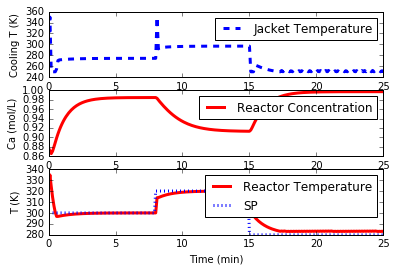

In [32]:
# PI design

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

# define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Input(3)
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)
    
    # State2 (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]
    
    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100.0
    # Volume of CSTR (m^3)
    V = 100.0
    # Density of A-B mixture (kg/m^3)
    rho = 1000.0
    # Heat Capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A-B (J/mol)
    mdelH = 5.0e4
    # E - Activation energy in the Arrhenius Equation(J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750.0
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall heat transfer coefficient (W/m^2-K)
    # A = Area - this value is specific for the U calcualtion (m^2)
    UA = 5.0e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca
    
    # Calculate concentration derivative
    dCadt = q/V*(Caf-Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf-T)+mdelH/(rho*Cp)*rA + UA/V/rho/Cp*(Tc-T)
    
    # Return xdot
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

Kp = 2.14287273905
taup = 0.914425164147
thetap = 5.58363624133e-05

# PID tuning
tauc = max(0.1*taup,0.8*thetap)
Kc = 3.8
tauI = 0.9
tauD = 0.0

# Steady state initial condition for the states
Ca_ss = 0.87725
T_ss = 324.4754
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss


# Steady state initial condition
u_ss = 300.0
# Feed temperature (K)
Tf = 350.0
# Feed concentration (mol/m^3)
Caf = 1.0

# Time interval (min)
t = np.linspace(0,25,251)

# store results for plotting
Ca = np.ones(len(t))*Ca_ss
T = np.ones(len(t))*T_ss
u = np.ones(len(t))*u_ss

# store PID results for plotting
sp = np.ones(len(t))* 300.0
sp[80:150]=320.0
sp[150:]=280.0
# op: operation parameter
op = np.zeros(len(t))
# pv: process variabel
pv = np.zeros(len(t))
# error
e = np.zeros(len(t))
# integral error
ie = np.zeros(len(t))
# derivative error
id = np.zeros(len(t))
P = np.zeros(len(t))
I = np.zeros(len(t))
D = np.zeros(len(t))


# upper and lower bounds of op
op_hi = 350.0
op_lo = 250.0


# simulate CSTR
for i in range(len(t)-1):
    delta_t = t[i+1]-t[i]
    ts = [t[i],t[i+1]]
    e[i] = sp[i]-pv[i]
    if i>=1:
        id[i]=(pv[i]-pv[i-1])/delta_t
        ie[i]=ie[i-1]+ e[i]*delta_t
    P[i] = Kc*e[i]
    I[i] = Kc/tauI*ie[i]
    D[i] = Kc*tauD*id[i]
    op[i]= op[0]+P[i]+I[i]+D[i]
    if op[i]>=op_hi:
        op[i] = op_hi
        ie[i]=ie[i-1]- e[i]*delta_t
    if op[i]<=op_lo:
        op[i] = op_lo
        ie[i]=ie[i-1]- e[i]*delta_t
    u[i+1]=op[i]
    y = odeint(cstr,x0,ts,args = (u[i+1],Tf,Caf))
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]
    pv[i+1] = T[i+1]
op[len(t)-1] = op[len(t)-2]
pv[len(t)-1] = pv[len(t)-2]
    


# plot the results
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,u,'b--',linewidth=3)
plt.ylabel('Cooling T (K)')
plt.legend(['Jacket Temperature'],loc='best')

plt.subplot(3,1,2)
plt.plot(t,Ca,'r-',linewidth=3)
plt.ylabel('Ca (mol/L)')
plt.legend(['Reactor Concentration'],loc='best')

plt.subplot(3,1,3)
plt.plot(t,T,'r-',linewidth=3,label='Reactor Temperature')
plt.plot(t,sp,'b:',linewidth = 3,label='SP')
plt.ylabel('T (K)')
plt.xlabel('Time (min)')
plt.legend(loc='best')

plt.show()





In [63]:
# Lowest Concentration

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from bokeh.plotting import figure, output_notebook,show

# define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Input(3)
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)
    
    # State2 (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]
    
    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100.0
    # Volume of CSTR (m^3)
    V = 100.0
    # Density of A-B mixture (kg/m^3)
    rho = 1000.0
    # Heat Capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A-B (J/mol)
    mdelH = 5.0e4
    # E - Activation energy in the Arrhenius Equation(J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750.0
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall heat transfer coefficient (W/m^2-K)
    # A = Area - this value is specific for the U calcualtion (m^2)
    UA = 5.0e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca
    
    # Calculate concentration derivative
    dCadt = q/V*(Caf-Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf-T)+mdelH/(rho*Cp)*rA + UA/V/rho/Cp*(Tc-T)
    
    # Return xdot
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

Kp = 2.14287273905
taup = 0.914425164147
thetap = 5.58363624133e-05

# PID tuning
tauc = max(0.1*taup,0.8*thetap)
Kc = 2.0
tauI = 1.2
tauD = 0.15

# Steady state initial condition for the states
Ca_ss = 0.87725
T_ss = 324.4754
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss


# Steady state initial condition
u_ss = 300.0
# Feed temperature (K)
Tf = 350.0
# Feed concentration (mol/m^3)
Caf = 1.0

# Time interval (min)
t = np.linspace(0,25,251)

# store results for plotting
Ca = np.ones(len(t))*Ca_ss
T = np.ones(len(t))*T_ss
u = np.ones(len(t))*u_ss

# store PID results for plotting
sp = np.ones(len(t))* 300.0
# steps should not be too large
for i in range(1,11):
    sp[20*i:]=300+i*10


# op: operation parameter
op = np.zeros(len(t))
# pv: process variabel
pv = np.zeros(len(t))
# error
e = np.zeros(len(t))
# integral error
ie = np.zeros(len(t))
# derivative error
id = np.zeros(len(t))
P = np.zeros(len(t))
I = np.zeros(len(t))
D = np.zeros(len(t))


# upper and lower bounds of op
op_hi = 350.0
op_lo = 250.0


# simulate CSTR
for i in range(len(t)-1):
    delta_t = t[i+1]-t[i]
    ts = [t[i],t[i+1]]
    e[i] = sp[i]-pv[i]
    if i>=1:
        id[i]=(pv[i]-pv[i-1])/delta_t
        ie[i]=ie[i-1]+ e[i]*delta_t
    P[i] = Kc*e[i]
    I[i] = Kc/tauI*ie[i]
    D[i] = Kc*tauD*id[i]
    op[i]= op[0]+P[i]+I[i]-D[i]
    if op[i]>=op_hi:
        op[i] = op_hi
        ie[i]=ie[i-1]- e[i]*delta_t
    if op[i]<=op_lo:
        op[i] = op_lo
        ie[i]=ie[i-1]- e[i]*delta_t
    u[i+1]=op[i]
    y = odeint(cstr,x0,ts,args = (u[i+1],Tf,Caf))
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]
    pv[i+1] = T[i+1]
op[len(t)-1] = op[len(t)-2]
pv[len(t)-1] = pv[len(t)-2]
    


# plot the results
output_notebook()

p1 = figure(plot_width = 400,plot_height = 200, y_axis_label='Jacket Temperature',
            x_axis_label='Time(sec)')
p1.line(t,u,line_color = 'blue',line_width = 3,legend='Temperature')

p2 = figure(plot_width = 400,plot_height = 200, y_axis_label='Ca (mol/L)',
            x_axis_label='Time(sec)')
p2.line(t,Ca,line_color = 'red',line_width = 3,legend='Concentration')

p3 = figure(plot_width = 400,plot_height = 200, y_axis_label='Reactor Temperature',
            x_axis_label='Time(sec)')
p3.line(t,T,line_color = 'blue',line_width = 3,legend='Reactor Temperature')
p3.line(t,sp,line_color = 'red',line_dash='3 3',line_width = 3,legend='SP')

show(p1)
show(p2)
show(p3)
# plt.figure()
# plt.subplot(3,1,1)
# plt.plot(t,u,'b--',linewidth=3)
# plt.ylabel('Cooling T (K)')
# plt.legend(['Jacket Temperature'],loc='best')

# plt.subplot(3,1,2)
# plt.plot(t,Ca,'r-',linewidth=3)
# plt.ylabel('Ca (mol/L)')
# plt.legend(['Reactor Concentration'],loc='best')

# plt.subplot(3,1,3)
# plt.plot(t,T,'r-',linewidth=3,label='Reactor Temperature')
# plt.plot(t,sp,'b:',linewidth = 3,label='SP')
# plt.ylabel('T (K)')
# plt.xlabel('Time (min)')
# plt.legend(loc='best')

# plt.show()





Loading BokehJS ...